In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay


# --- Limpieza de datos según lo indicado ---
df = pd.read_csv('data/titanic.csv')
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df = pd.get_dummies(df)
del df['Sex_female']
df['Age'] = df['Age'].fillna(df.Age.mean())

# Variables predictoras y variable objetivo
X = df.drop('Survived', axis=1)
y = df['Survived']

# --- División en conjunto de entrenamiento y test (80%-20%) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
# Crea un gradient boosting
# Ejempolo gradient boosting
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=300, learning_rate=0.1, max_depth=4)
model.fit(X_train, y_train)

GradientBoostingClassifier(max_depth=4, n_estimators=300)

In [12]:
predicciones = model.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, predicciones)

0.7853754940711462

In [8]:
## Cross validation 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('gbt', GradientBoostingClassifier(n_estimators=300))
])
params = {
    'gbt__max_depth': [2, 3, 4, 5],
    'gbt__learning_rate': [0.1, 0.5, 0.01]
}

grid_gbt = GridSearchCV(pipeline, param_grid=params, cv=3, n_jobs=-1, scoring='roc_auc').fit(X_train, y_train)

In [9]:
# Mejor estimador
grid_gbt.best_params_

{'gbt__learning_rate': 0.01, 'gbt__max_depth': 2}

In [13]:
# r2 score
best_model = grid_gbt.best_estimator_.named_steps['gbt']
predicciones = best_model.predict_proba(X_test)[: ,1]
roc_auc_score(y_test, predicciones)

0.8291172595520423

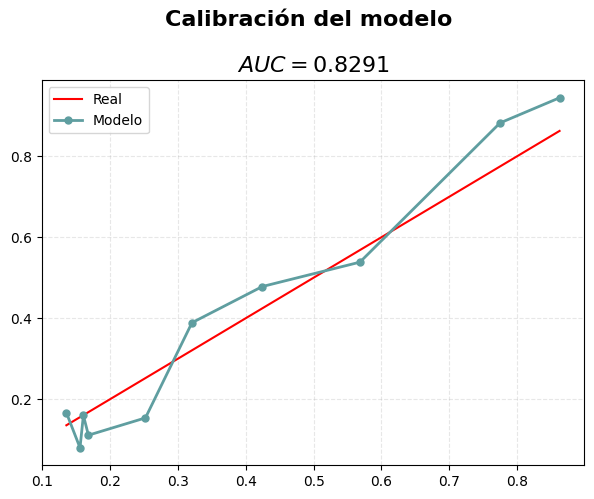

In [18]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
    grouped = df_calibracion.groupby('bins').mean()
    auc = roc_auc_score(y_score=predicciones, y_true=y)
    
    # Gráfica
    plt.figure(figsize=(7,5))
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=1.5)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=5, lw=2)
    plt.title(f'Calibración del modelo \n\n$AUC={auc:.4f}$', fontsize=16, fontweight='bold')
    plt.grid(alpha=0.3, ls='--')
    plt.legend()
    plt.show()

calibracion(predicciones, y_test, 10)

In [15]:
# Entendiendo el modelo 
importancias = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
})
importancias.sort_values('importance', ascending=False)

,feature,importance
5,Sex_male,0.606826
0,Pclass,0.185683
1,Age,0.110098
4,Fare,0.062803
2,SibSp,0.017175
8,Embarked_S,0.014344
3,Parch,0.003071
6,Embarked_C,0.000000
7,Embarked_Q,0.000000


c:\Users\epile\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])


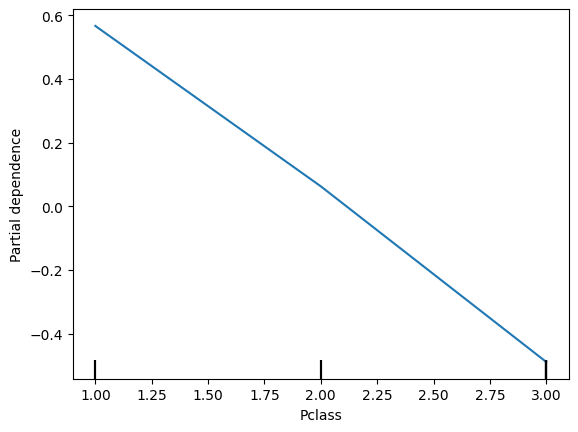

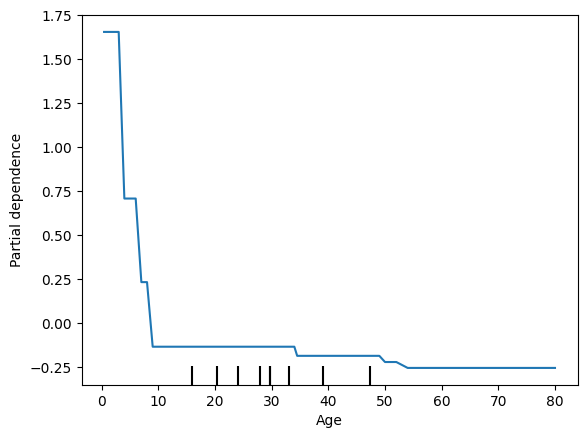

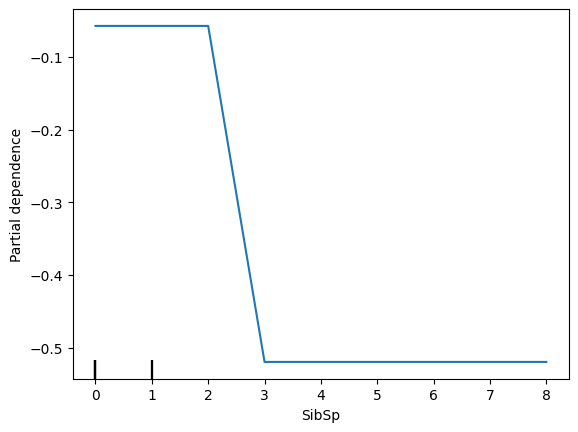

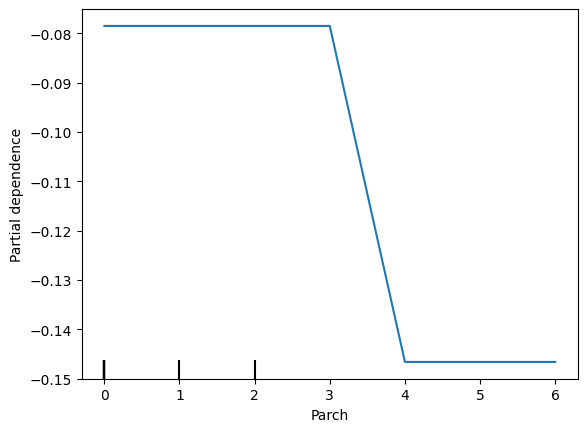

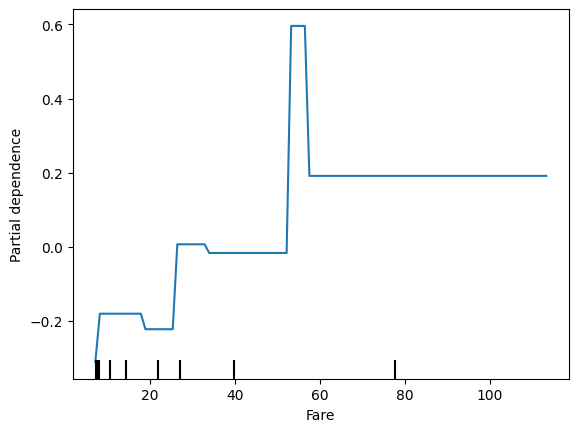

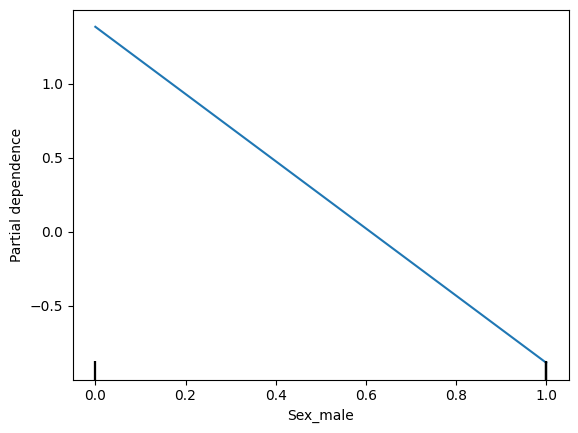

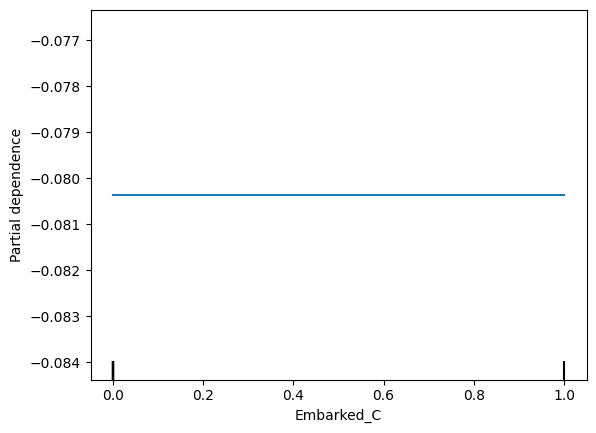

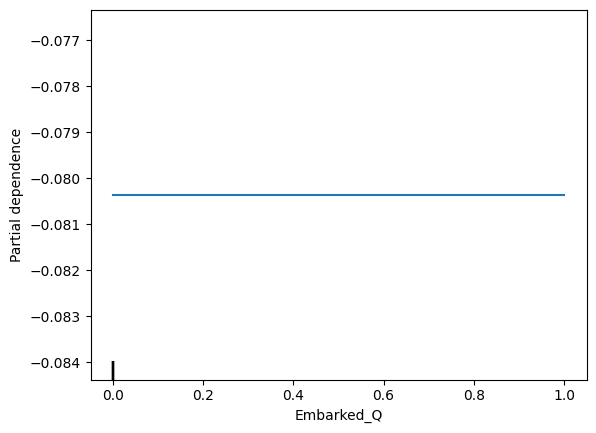

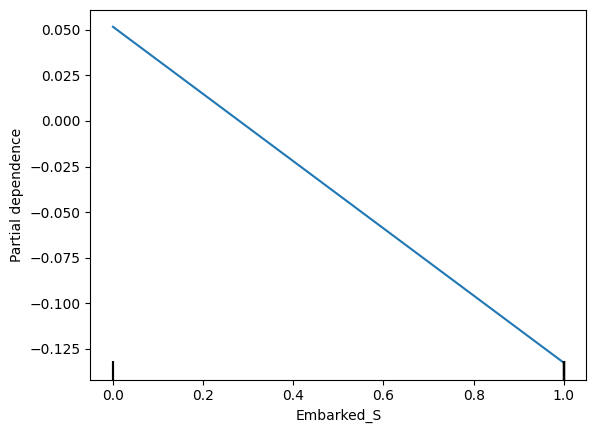

In [20]:
# Codigo for para partial dependence plot 
from sklearn.inspection import PartialDependenceDisplay

for i in range(len(X_train.columns)):
    PartialDependenceDisplay.from_estimator(
    best_model,
    X_train,
    [i],
    feature_names=X_train.columns
    )